In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from scipy.stats import norm

# Preprocess the data

In [2]:
def pre_process (files_list: list) -> DataFrame:
    
    '''
    This function is to iterate each file in the fold and pre-process the data. 
    It first converts the date column to datetime format, then sets the 'Date' column as index, 
    and then picks the 'Close' column (close price) which is the focus of this analysis to put it in the empty dataframe.
    '''
    
    # create an empty dataframe with the column inside files_list
    df = pd.DataFrame(index = [], columns=files_list)

    for file_name in files_list:
        df_company = pd.read_csv(file_name)
        df_company['Date'] = pd.to_datetime(df_company.Date)
        df_company = df_company.set_index('Date')
        df[file_name] = df_company['Close']
        
        #tidy up the file_name to be use it in the rename function
        company_name = file_name.replace("Year_2021\\","").replace(".csv","")

        #rename columns
        df = df.rename(columns={file_name : company_name})
    
    return df

In [3]:
files_list = glob.glob("Year_2021/*")
df = pre_process (files_list)
df

,KAOOY,PG,UL
Date,,,
2020-03-27,16.450001,110.169998,49.250000
2020-03-30,16.299999,115.000000,50.580002
2020-03-31,16.280001,110.000000,50.570000
2020-04-01,15.070000,109.330002,49.180000
2020-04-02,15.350000,114.400002,50.770000
...,...,...,...
2021-03-22,13.220000,130.179993,55.669998
2021-03-23,13.250000,132.600006,56.020000
2021-03-24,13.260000,132.559998,55.660000


<AxesSubplot:xlabel='Date'>

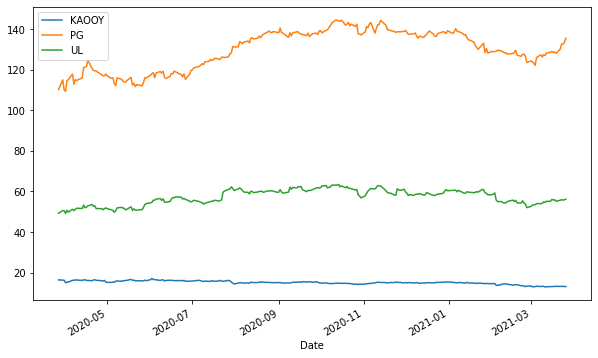

In [4]:
#plot the graph to compare the prices of the companies
df.plot(legend = True, figsize=(10,6))

In [5]:
def predict_price(df: pd.DataFrame, predict_days: int, predict_count: int) -> pd.DataFrame:
    col_list = []
    
    '''
    This function is to predict the price of a single company using Monte Carlo Simulation.
    It calculates the result of each varibale in the formula of Monte Carlo Simulation and plug the results into the formula.
    
    df: dataframe from the last function
    predict_days: number of days we need to forecast for
    predict_count: how many predictions we need for each day
    '''
    
    #calculate log return
    daily_returns = df.pct_change()
    log_returns = np.log(1 + daily_returns)
        
    #caculate the drift
    avg = log_returns.mean()
    var = log_returns.var()
    drift = avg - (var/2.0)
    drift = np.array(drift)
        
    #caculate Rv
    std = log_returns.std()
    std = np.array(std)
    x = np.random.rand(predict_days+1, predict_count) #(row, colum)
    Rv = std*norm.ppf(x)
        
    #take e to the power of (drift + Rv)
    e_value = np.exp(drift + Rv)

    #take the last price of the company
    current_price = df.iloc[-1]
        
    #make the first row of the array the current price
    new_price = np.zeros_like(e_value)
    new_price[0] = current_price
        
    for i in range(1, predict_days+1):
        #predict the future price using the formula for number of days indicated in predict_days
        new_price[i] = new_price[i - 1]*e_value[i]
        df_predict = pd.DataFrame(new_price)
   
    #tidy up the dataframe by renaming the column and index
    for num in range (1, predict_count+1):
        col_name = 'Prediction ' + str(num)
        col_list.append(col_name)
    df_predict.columns = col_list
    df_predict.index.name = 'Day'
    
    return df_predict

Text(0, 0.5, 'Predicted price')

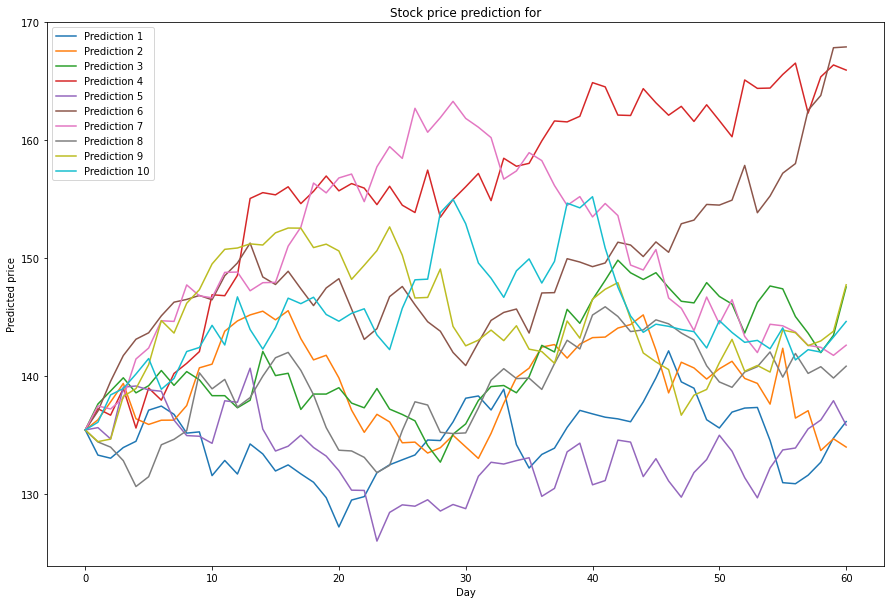

In [7]:
df_predict = predict_price(df = df['PG'], predict_days = 60, predict_count = 10)

#plot the graph
df_predict.plot(legend = True, figsize=(15, 10), title='Stock price prediction for')
plt.ylabel('Predicted price')